In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import requests
from bs4 import BeautifulSoup as bs
import zipfile
import io
import json
import matplotlib.dates as mdates
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import NumeralTickFormatter
from bokeh.io import output_notebook, show
from bokeh.models import FactorRange, HoverTool
from bokeh.plotting import figure
from bokeh.palettes import Spectral5
output_notebook()

Loading BokehJS ...

In [2]:
url = "https://webrobots.io/kickstarter-datasets/"
response = requests.get(url)
soup = bs(response.content, "html.parser")
csv_links = []

# Find links to CSV files
for link in soup.find_all('a'):
    href = link.get('href')
    if href and href.endswith('.zip'):
        filename = href.split("/")[-1]
        date_str = filename.split("_")[1]
        if date_str >= "2020-12":
            csv_links.append(href)

# Download and process CSV files
dfs = []
for link in csv_links:
    response = requests.get(link)
    zip_file = io.BytesIO(response.content)
    # Extract CSV files from the zip archive and load them into pandas dataframes
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        csv_files = [name for name in zip_ref.namelist() if name.endswith('.csv')]
        for csv_file in csv_files:
            with zip_ref.open(csv_file) as file:
                df = pd.read_csv(file)
                df = df.rename(columns={'goal': 'goal_usd'})
                # Keep only the desired columns
                columns_to_keep = [ 'launched_at', 'backers_count','country','state', 'usd_pledged', 'category','goal_usd']
                df = df[columns_to_keep]
                # Convert date columns to datetime
                df['launched_at'] = pd.to_datetime(df['launched_at'], unit='s')
                
                
            dfs.append(df)

# Concatenate all dataframes into one
df_webrobot = pd.concat(dfs)

The code scraping links to CSV files from a web page, downloads and processes those files, and concatenates the resulting DataFrames into a single DataFrame (df_webrobot). The processing steps include renaming columns, selecting specific columns, and converting the 'launched_at' column to datetime format.

In [3]:
def get_category_name(json_str):
    data = json.loads(json_str)
    return data.get('parent_name','unknown')

df_webrobot['category'] = df_webrobot['category'].apply(get_category_name)

this code will extract the parent name from the JSON string in the 'category' column.then We downloaded the data from Kaggle and displayed the DataFrame.

In [4]:
df_webrobot

,launched_at,backers_count,country,state,usd_pledged,category,goal_usd
0,2016-03-16 14:35:24,362,US,successful,88701.000000,Technology,75000.0
1,2016-03-15 17:05:02,125,US,successful,124293.000000,Technology,115000.0
2,2016-03-09 12:01:08,252,US,successful,76694.000000,Technology,50000.0
3,2016-03-08 12:26:58,22,CA,successful,1195.593020,Technology,400.0
4,2016-03-05 00:01:27,484,US,successful,21850.990000,Technology,15000.0
...,...,...,...,...,...,...,...
3145,2017-05-31 17:37:07,1,US,failed,10.000000,Publishing,500.0
3146,2015-01-28 16:43:38,6,GB,failed,244.588849,Film & Video,30000.0
3147,2017-07-29 03:07:34,5,MX,canceled,287.559221,Food,350000.0
3148,2015-08-30 21:17:44,51,GB,successful,1683.874823,Music,1000.0


This code will extract the parent_name from the JSON string in the 'category' column. Next step is to download the data from Kaggle and displayed the DataFrame.

In [5]:
df_kaggle =pd.read_csv('Kickstarter Campaigns DataSet.csv' , index_col=0)
df_kaggle = df_kaggle[['launched_at', 'backers_count', 'country','status', 'usd_pledged', 'sub_category', 'goal_usd']]
df_kaggle = df_kaggle.rename(columns={'status': 'state', 'sub_category': 'category'})
df_kaggle['category'] = df_kaggle['category'].str.capitalize()
df_kaggle

,launched_at,backers_count,country,state,usd_pledged,category,goal_usd
0,2018-02-10 22:47:52,16,CA,failed,577.902078,Food,785.82065
1,2014-11-21 10:42:26,7,US,successful,211.000000,Publishing,93.00000
2,2020-10-19 05:26:59,99,US,successful,4697.000000,Food,1500.00000
3,2019-05-29 16:01:34,3,US,failed,222.000000,Technology,25000.00000
4,2015-11-19 20:36:01,100,US,successful,5410.000000,Publishing,5000.00000
...,...,...,...,...,...,...,...
217248,2017-05-31 17:37:07,1,US,failed,10.000000,Publishing,500.00000
217249,2015-01-28 16:43:38,6,GB,failed,244.588849,Film & video,40621.01400
217250,2017-07-29 03:07:34,5,MX,canceled,287.559221,Food,17662.55400
217251,2015-08-30 21:17:44,51,GB,successful,1683.874823,Music,1354.03380


Eventually we concatinante the data from webrobot und kaggle.

In [6]:
df = pd.concat([df_webrobot, df_kaggle], axis=0)
df['category'] = df['category'].str.lower().str.strip()

In [7]:
print("duplicates: ", df.duplicated().sum())
df.drop_duplicates(inplace=True, ignore_index=True)

# original row-length was  1885897. check after removal of duplicates
print("length of dataset after removal of duplicates is ", len(df))

duplicates:  1885897
length of dataset after removal of duplicates is  463396


We observed a limited amount of data available before the year 2010. In order to ensure the reliability of our analysis, we have made the decision to exclude this earlier period from our dataset.

In [8]:
#Convert the 'launched_at' column to datetime format
df['launched_at'] = pd.to_datetime(df['launched_at'])
# Create a timestamp for January 1st, 2010
start_date = pd.Timestamp('2010-01-01')

# Filter the dataframe to only include rows where launched_at is after or equal to start_date
df = df[df['launched_at'] >= start_date]

In [9]:
unknown_count = df[df['category'] == 'unknown'].shape[0]
print(f"Number of projects 'unknown': {unknown_count}")

df.drop(df[df['category'] == 'unknown'].index, inplace=True)

Number of projects 'unknown': 15519


In [10]:
counts = df['category'].value_counts()

#Create the figure and plot
p = figure(x_range=list(counts.index), plot_height=400, plot_width=800,
           title= '  Number of Projects by Category  (2010 - 2022) ', toolbar_location=None, tools="")
p.vbar(x=list(counts.index), top=counts.values, width=0.5, fill_color='steelblue')

#the plot
p.title.text_font_size = '16px'
p.xaxis.axis_label = 'Category'
p.yaxis.axis_label = 'Count'
p.yaxis.formatter = NumeralTickFormatter(format='0,0')
p.xaxis.major_label_orientation = 1.2

show(p)

The resulting plot visualizes the number of projects by category, with each category represented by a vertical bar. The bar plot indicates that categories such as Film & Video, Music, Technology, Art, and Publishing have a higher number of projects compared to other categories. While this suggests that these categories are popular and attract a significant number of project creators, it does not provide direct information about their success.

In [11]:
total_pledged_amount = df['usd_pledged'].sum()
print(f"Total pledged amount (2010-2023) in US dollars: ${total_pledged_amount:,.2f}")
max_pledged_amount = df['usd_pledged'].max()/1000000
print(f'Maximum amount pledged',  max_pledged_amount ,' Millon dollars')

Total pledged amount (2010-2023) in US dollars: $6,798,048,342.83
Maximum amount pledged 41.75415324  Millon dollars


The dataset spans from 2010 to 2023 and the total pledged amount across all projects in the dataset exceeds 6.5 billion dollars. Furthermore, we observed a wide range of project goals, with the minimum goal starting as low as 1 cent and the maximum reaching as high as $41.5 million dollars. This diverse range of goals highlights the varying scales and ambitions of the projects launched on Kickstarter.

In [12]:
# Calculate the percentage of failed projects 
total_projects = len(df)
failed_projects = len(df[df['state'] == 'failed'])
percentage_failed = (failed_projects / total_projects) * 100

print(f"Percentage of projects that failed to meet their minimum goal: {percentage_failed:.2f}%")

Percentage of projects that failed to meet their minimum goal: 35.57%


In [13]:
total_pledged_amount = df['usd_pledged'].sum()
num_reached_goal = df[df['usd_pledged'] >= df['goal_usd']].shape[0]
percentage_reached_goal = (num_reached_goal / df.shape[0]) * 100
print("Percentage of projects that reached their funding goal:", percentage_reached_goal, "%")
df.describe()

Percentage of projects that reached their funding goal: 51.81012723317586 %


,backers_count,usd_pledged,goal_usd
count,447289.000000,4.472890e+05,4.472890e+05
mean,160.085068,1.519834e+04,5.126263e+04
std,1025.173964,1.411500e+05,1.248445e+06
min,0.000000,0.000000e+00,5.016227e-01
25%,4.000000,1.095917e+02,1.500000e+03
50%,27.000000,1.546653e+03,5.000000e+03
75%,93.000000,6.829773e+03,1.500000e+04
max,185341.000000,4.175415e+07,1.354034e+08


A significant finding is that approximately 52% of campaigns successfully reach their funding goal. This highlights the critical importance for creators to understand the factors that can potentially impact the outcome of their project prior to launching. By gaining insights into these factors, creators can make informed decisions and increase their chances of achieving their funding goals.

In [14]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 447289 rows and 7 columns


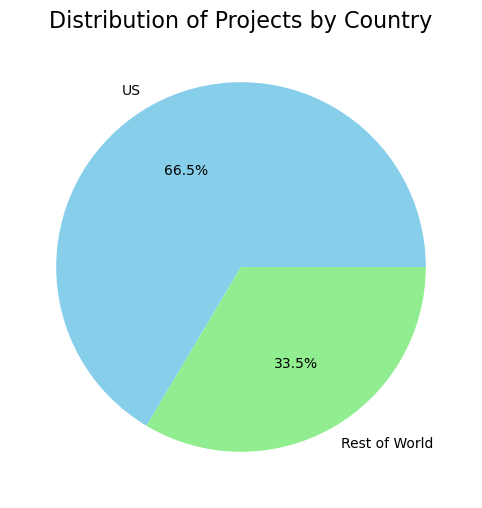

In [15]:
# Count the number of projects in the US and the rest of the world
us_projects = df[df['country'] == 'US'].shape[0]
rest_of_world_projects = df[df['country'] != 'US'].shape[0]

data = {'Country': ['US', 'Rest of World'], 'Number of Projects': [us_projects, rest_of_world_projects]}
df_projects = pd.DataFrame(data)

# Plot the distribution of projects as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(df_projects['Number of Projects'], labels=df_projects['Country'], autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])

plt.title('Distribution of Projects by Country', fontsize=16)

plt.show()

Based on the distribution of projects by country dislpayed in the graph, a significant observation is that the United States has the highest number of projects, accounting for approximately 66.5% of the total. This dominance indicates the outstanding of the USA in Kickstarter projects compared to other countries.

As a result, we have decided to focus our study specifically on projects in the USA. By narrowing our analysis to this region, we aim to gain deeper insights into the factors influencing project outcomes within the United States.

C:\Users\ilyes\AppData\Local\Temp\ipykernel_80480\3446158270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_us['year'] = df_us['launched_at'].dt.year


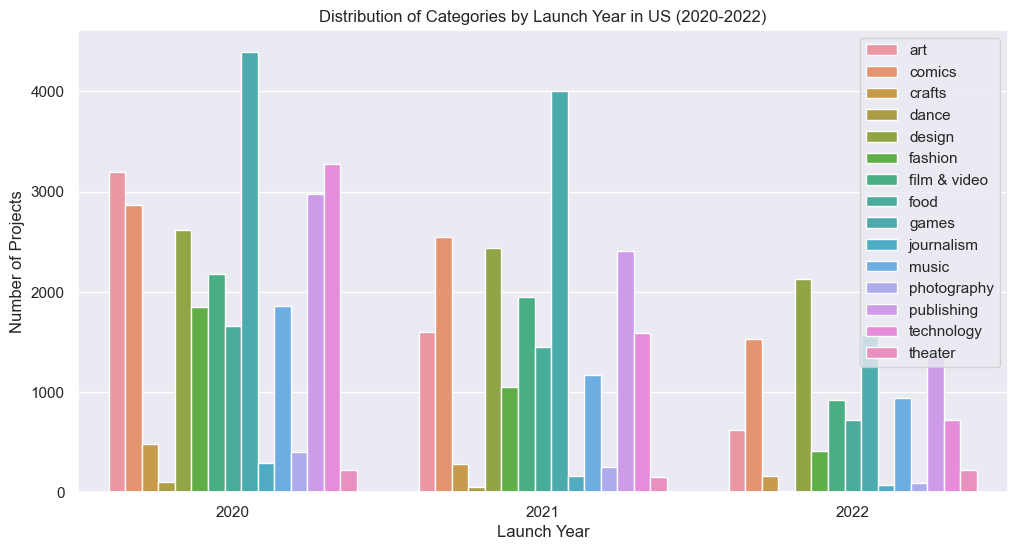

In [16]:
df_us = df[df['country'] == 'US']
df_us['year'] = df_us['launched_at'].dt.year

df_us_last_years = df_us[df_us['year'].isin([2020, 2021, 2022])]
category_counts = df_us_last_years.groupby(['category', 'year'])['category'].count().reset_index(name='count')
#cerate plot
sns.set(style='darkgrid')
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='count', hue='category', data=category_counts)
plt.title('Distribution of Categories by Launch Year in US (2020-2022)')
plt.xlabel('Launch Year')
plt.ylabel('Number of Projects')
plt.legend(loc='upper right')
plt.show()


This plot provides a visual representation of how the distribution of project categories has changed over time in the US, specifically focusing on the years 2020, 2021, and 2022. It allows for a quick comparison of the number of projects across different categories within each year and also shows any trends or shifts in category popularity over the selected years.

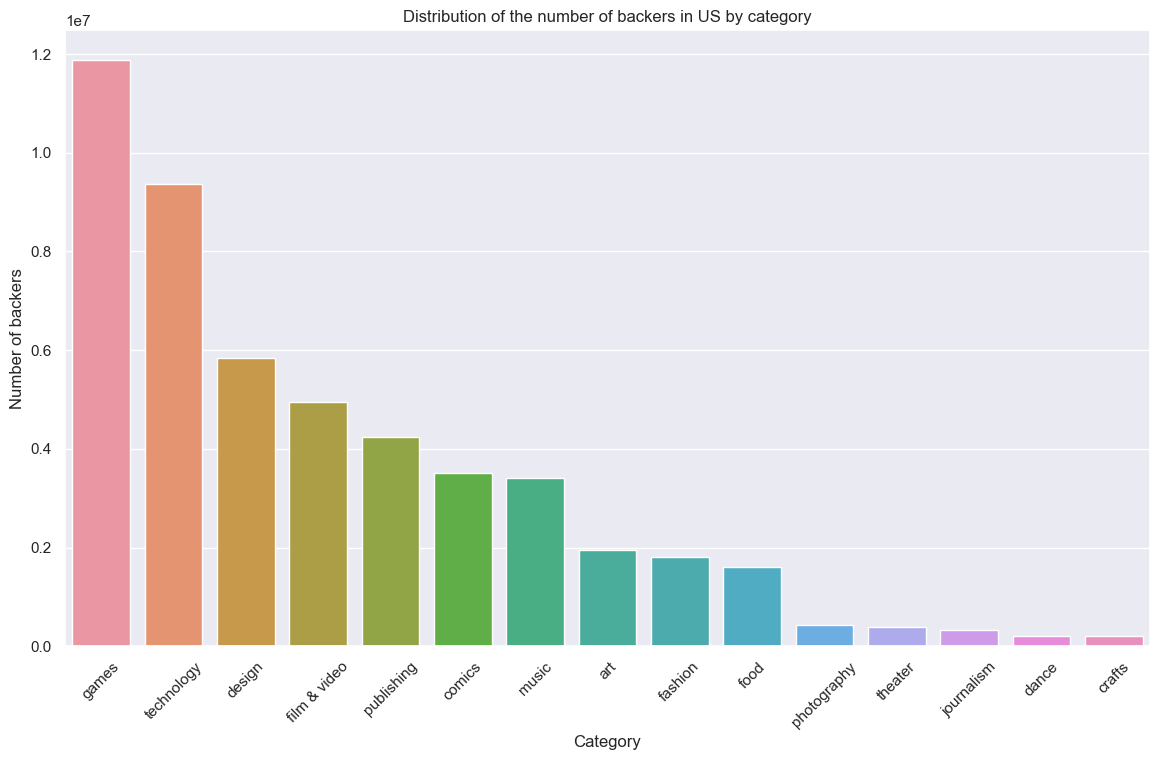

In [17]:
# Sort the DataFrame by the 'backers_count' column in descending order
category_backers_counts = df_us.groupby('category')['backers_count'].sum().reset_index()
category_backers_counts = category_backers_counts.sort_values('backers_count', ascending=False)

# Create the bar plot
sns.set(style='darkgrid')
plt.figure(figsize=(14, 8))
sns.barplot(x='category', y='backers_count', data=category_backers_counts)
plt.title('Distribution of the number of backers in US by category')
plt.xlabel('Category')
plt.ylabel('Number of backers')

plt.xticks(rotation=45)

plt.show()


The number of backers has been identified as a crucial factor influencing investment decisions in projects. When comparing two investment options, project A and project B, if project B currently has a substantially higher number of backers than project A, it is highly likely that an investor will choose to invest in project B.

Our analysis focused on determining which categories of projects attract the highest number of backers. The findings revealed that games, specifically successful game projects, tend to have the largest number of backers.

Text(117.24999999999999, 0.5, 'Category')

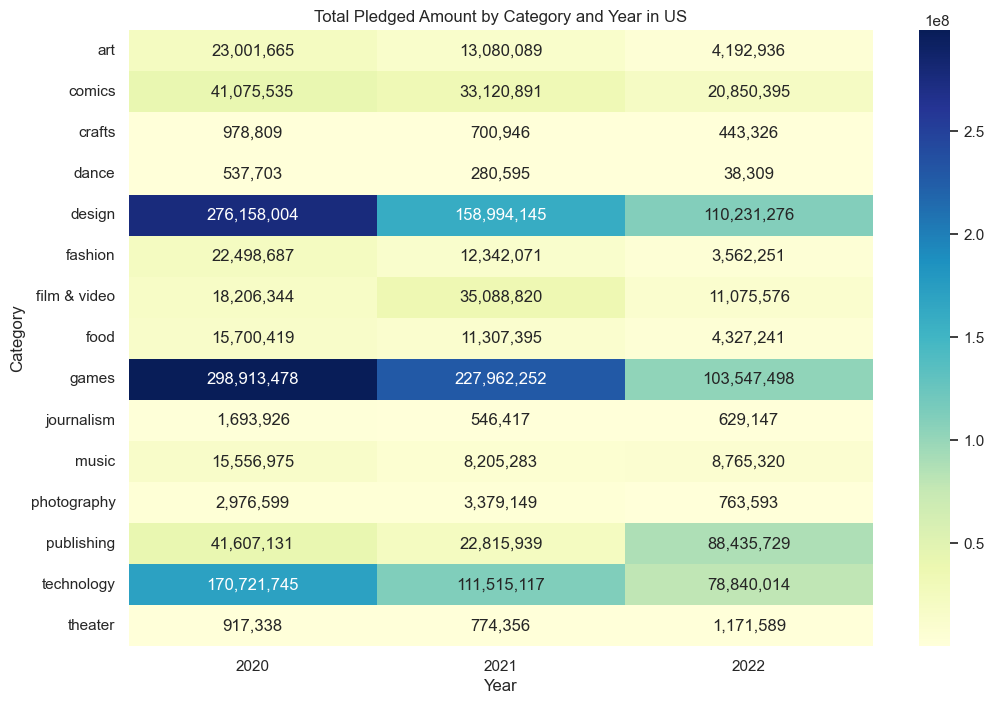

In [18]:
# Pivot the data into a matrix
category_year_matrix = df_us_last_years.pivot_table(values='usd_pledged', index='category', columns='year', aggfunc='sum')
# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(category_year_matrix, cmap="YlGnBu", annot=True, fmt=",.0f")
plt.title('Total Pledged Amount by Category and Year in US')
plt.xlabel('Year')
plt.ylabel('Category')

The analysis of the Pledged Amount by category and years confirms the previous findings regarding the popularity of games as an investment category. The data shows that games have received the highest amount of pledged funds, totaling $298,913,478, making it the most popular category among investors. This aligns with the earlier observation that games also attracted the largest number of backers in the United States. The consistency between the two sets of data might indicate that games have a significant appeal and potential for investment.

In [19]:
df_us_last_years['launched_at'] = pd.to_datetime(df_us_last_years['launched_at'])
df_us_last_years['year'] = df_us_last_years['launched_at'].dt.year

# Group the data by category and state and count the number of projects in each group
category_state_counts = df_us_last_years.groupby(['category', 'state'])['state'].count().reset_index(name='count')

# Pivot the data to create a table with categories as rows and project states as columns
category_state_counts_pivot = category_state_counts.pivot(index='category', columns='state', values='count').fillna(0)

# Define the project states and their corresponding colors
states = ['successful', 'failed', 'canceled', 'live', 'suspended']
colors = ['green', 'red', 'black', 'blue', 'purple']

# Create the stacked bar chart
p = figure(x_range=FactorRange(*category_state_counts_pivot.index), plot_height=400, plot_width=1000, title=' Distribution of Project States by Category in US (2020 - 2022)')
renderers = p.vbar_stack(stackers=states, x='category', color=colors, source=category_state_counts_pivot, legend_label=states)

# Add tooltips to display the exact counts
tooltips = [(state, f'@{state}') for state in states]
p.add_tools(HoverTool(renderers=renderers, tooltips=tooltips))

# Set the axis labels and legends
p.xaxis.axis_label = 'Category'
p.yaxis.axis_label = 'Number of Projects'
p.legend.title = 'State'
show(p)


C:\Users\ilyes\AppData\Local\Temp\ipykernel_80480\1337683720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_us_last_years['launched_at'] = pd.to_datetime(df_us_last_years['launched_at'])
C:\Users\ilyes\AppData\Local\Temp\ipykernel_80480\1337683720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_us_last_years['year'] = df_us_last_years['launched_at'].dt.year


The high amount of projects in the games category suggests its popularity among investors.

Despite this fact, it does not necessarily mean that games are more successful than other categories.The success of a project depends on multiple factors beyond funding, such as game quality and market demand. Therefore, it is important to consider various factors before concluding and conduct more research on the data.